## Record Lambdas experiment

I recorded each lambda in the first element of the batch with the idea of observing if lambdas stabilize over time.

The results indicate that if the depth is greater than 3, the lambdas are not stable. This can be observed as oscillations between positive and negative values.

### Results

- The experiments suggest the need to rethink how we search the tree to prevent such oscillations.
- The number of oscillations is proportional to the depth of the tree and occurs when the lambda at the upper level is close to zero.
- Oscillations are not a problem if the depth is less than 2.
- Oscillations are correlated with network learning and unlearning, which manifests as a decrease in accuracy.

The plots below depict how the lambdas change over time.

In [2]:
from typing import Optional
from math import floor, log2, sqrt

import torch as torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [3]:
INIT_STRAT = 'hyperspherical-shell'


class FFF(nn.Module):
    def __init__(self, nIn: int, nOut: int, depth: Optional[int] = None):
        super().__init__()
        self.depth = depth or int(floor(log2(nIn)))  # depth is the number of decision boundaries
        nNodes = 2 ** self.depth - 1

        self.lambdas = []

        # each node "holds" a basis-vector in INPUT space (.X) and in OUTPUT space (.Y)

        if INIT_STRAT == 'gaussian':
            # This from orig authors; scaling looks off for self.Y
            def create_basis_vectors_of(length, scaling):
                return nn.Parameter(torch.empty(nNodes, length).uniform_(-scaling, scaling))
            self.X = create_basis_vectors_of(length=nIn, scaling=1/sqrt(nIn))
            self.Y = create_basis_vectors_of(length=nOut, scaling=1/sqrt(self.depth + 1))

        elif INIT_STRAT == 'hyperspherical-shell':
            # Initialize vectors on INPUT/OUTPUT space unit hypersphere
            #   (idea: basis vectors should be of unit length).
            def create_random_unit_vectors_of(length):
                weights = torch.randn(nNodes, length)  # Initialize weights randomly
                weights = F.normalize(weights, p=2, dim=-1)  # L2-Normalize along the last dimension
                return nn.Parameter(weights)
            self.X = create_random_unit_vectors_of(length=nIn)
            self.Y = create_random_unit_vectors_of(length=nOut)

    def clear_lambdas(self):
        self.lambdas = []

    def get_lambdas(self):
        return self.lambdas

    def push_away_loss(self, x: torch.Tensor):
        return torch.pow((1 - torch.abs(x)), 2).sum()

    def forward(self, x: torch.Tensor, train_key=False, save_lambda=False):
        nBatch, nIn, nOut = x.shape[0], self.X.shape[-1], self.Y.shape[-1]

        current_node = torch.zeros(nBatch, dtype=torch.long, device=x.device)
        if train_key:
            current_loss = torch.tensor(0.0, device=x.device)

        # Walk the tree, assembling y piecemeal
        y = torch.zeros((nBatch, nOut), dtype=torch.float, device=x.device)
        for depth in range(self.depth):
            # Project x onto the current node's INPUT basis vector
            #   λ = x DOT currNode.X
            # (nBatch, nIn,) (nBatch, nIn) -> (nBatch,)
            λ = torch.einsum("b i, b i -> b", x, self.X[current_node])

            if save_lambda:
                self.lambdas.append(λ.detach().cpu().numpy())

            if train_key:
                current_loss += self.push_away_loss(λ)

            y += torch.einsum("b, b j -> b j", λ, self.Y[current_node])

            branch_choice = (λ > 0.0).long()
            current_node = (current_node * 2) + 1 + branch_choice

        if train_key:
            return y, current_loss
        return y


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Net_FFF(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = FFF(16 * 5 * 5, 120, depth=None)
        self.fc2 = FFF(120, 84, depth=None)
        self.fc3 = FFF(84, 10, depth=None)

    def forward(self, x, train_key=False, save_lambda=False):
        train_key = False
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x= F.relu(self.fc1(x, train_key=train_key, save_lambda=save_lambda))
        x = F.relu(self.fc2(x, train_key=train_key, save_lambda=save_lambda))
        x = self.fc3(x, train_key=train_key, save_lambda=save_lambda)
        return x

In [6]:

def evaluate(net: nn.Module, data_loader: torch.utils.data.DataLoader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    return 100 * correct / total

def train(net: nn.Module,
          trainloader: torch.utils.data.DataLoader,
          testloader: torch.utils.data.DataLoader,
          epochs: int):

    optimizer = optim.AdamW(net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs, train_key=True, save_lambda= i == 0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch} loss: {running_loss / len(trainloader)}")

In [7]:
net_FFF = Net_FFF().to(device)

In [8]:
train_for = 40
train(net_FFF, trainloader, testloader, train_for)

Epoch 0 loss: 2.0156011249098325
Epoch 1 loss: 1.67820561480949
Epoch 2 loss: 1.5400460501156195
Epoch 3 loss: 1.446976042159683
Epoch 4 loss: 1.3739027166000717
Epoch 5 loss: 1.3142818557027052
Epoch 6 loss: 1.2643105567568709
Epoch 7 loss: 1.2199905717464359
Epoch 8 loss: 1.180584633594279
Epoch 9 loss: 1.1504579206256915
Epoch 10 loss: 1.1264083525713753
Epoch 11 loss: 1.096750738370754
Epoch 12 loss: 1.0802907425424326
Epoch 13 loss: 1.0531655925009258
Epoch 14 loss: 1.0313537155880648
Epoch 15 loss: 1.0108696385417753
Epoch 16 loss: 0.9938559431554107
Epoch 17 loss: 0.9752040802670257
Epoch 18 loss: 0.9600328673487124
Epoch 19 loss: 0.9481354689659061
Epoch 20 loss: 0.9401206336058009
Epoch 21 loss: 0.9212471045496519
Epoch 22 loss: 0.9122932800246627
Epoch 23 loss: 0.9018448813796958
Epoch 24 loss: 0.8863150346309633
Epoch 25 loss: 0.8682483523093221
Epoch 26 loss: 0.8589129655257516
Epoch 27 loss: 0.8496522891247059
Epoch 28 loss: 0.8345596445795825
Epoch 29 loss: 0.832286869625

In [22]:
def plot_FFF_net(samples: list[int], epoch, n_layers=3):
  _, axs = plt.subplots(
    len(samples), 3,
    figsize=(4 * n_layers, 3*len(samples)),
    sharex=True, sharey=True
  )

  def plot_FFF_layer(weight: np.ndarray, element: int, layer: str):
    for i in range(depth):
      color = plt.cm.viridis(i / depth)
      plt.plot(weight[:, i], label=f'depth {i}', color=color, alpha=0.9)
    plt.title(f'layer = {layer}, idx={element}')
    plt.axhline(y=0, color='k', linestyle='--')


  for j, sample in enumerate(samples):
    for i in range(n_layers):
      weights = np.array(eval(f'net_FFF.fc{i+1}.get_lambdas()'))
      depth = weights.shape[0] // epoch
      weightsReshaped = weights.reshape(epoch, depth, weights.shape[-1])
      weightOverTime = weightsReshaped[:, :, sample]

      plt.sca(axs[j, i])
      plot_FFF_layer(weightOverTime, sample, f'fc{i+1}')

  plt.tight_layout()
  plt.show()

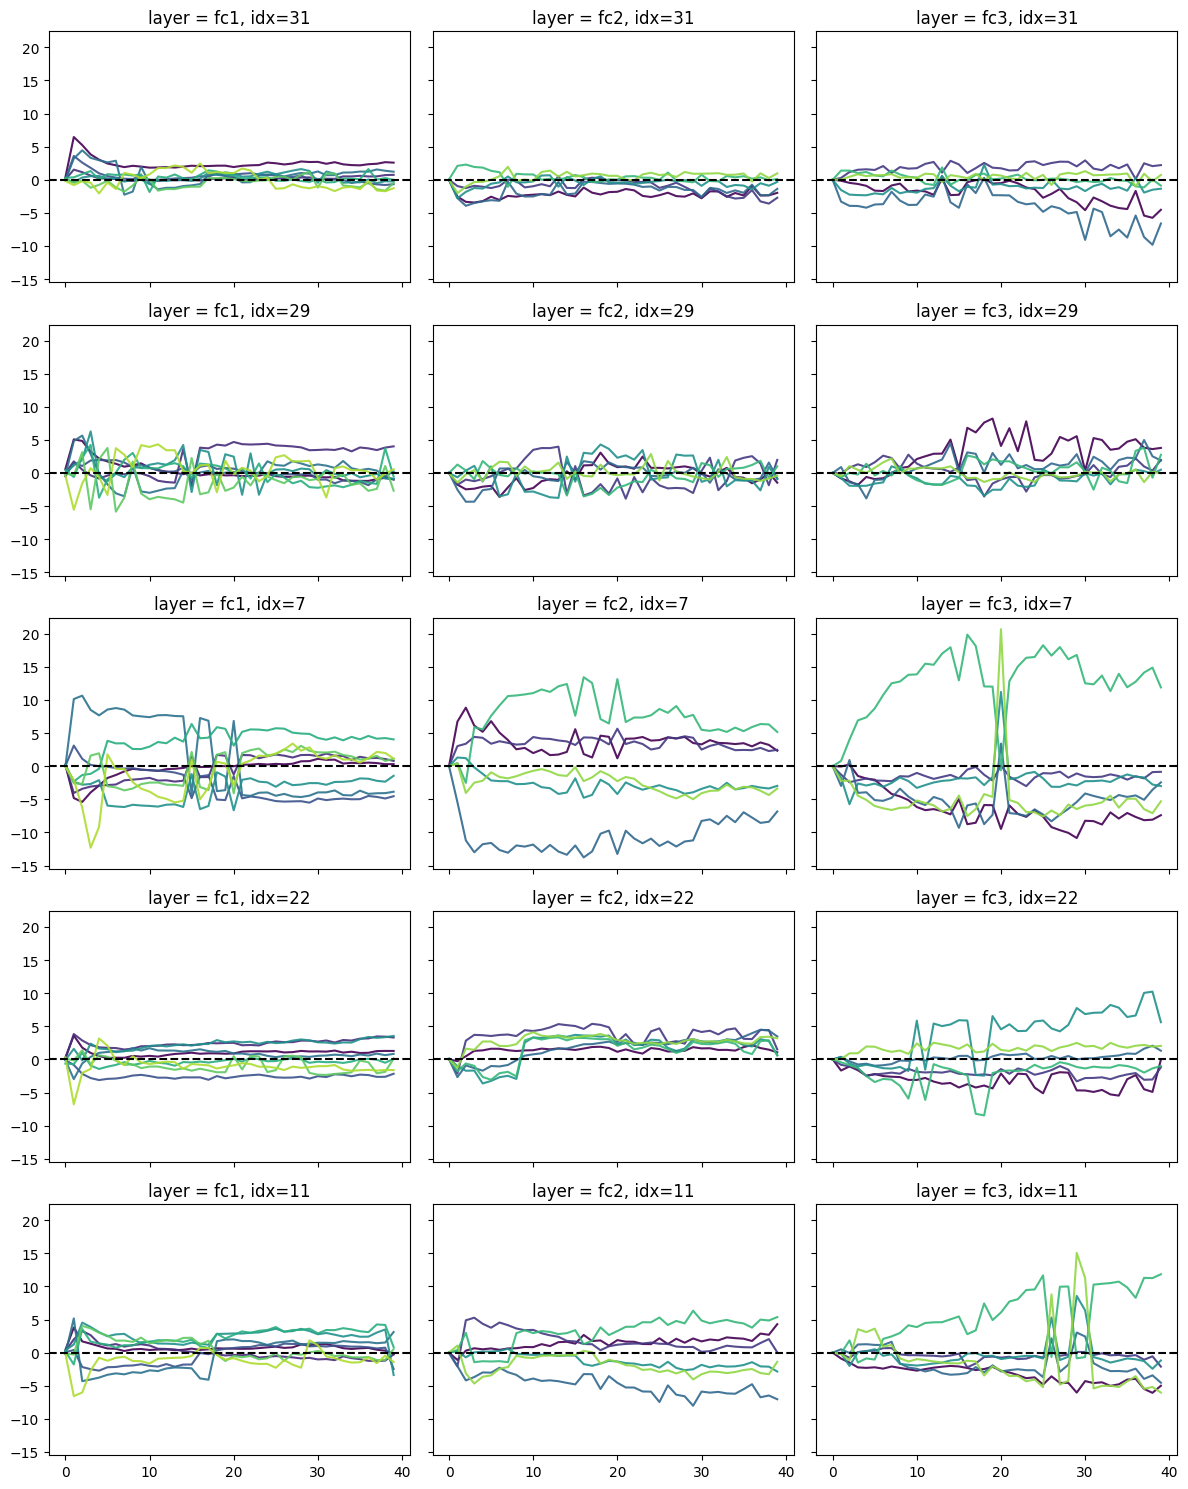

In [23]:
plot_FFF_net(samples=np.random.choice(train_for, 5, replace=False), epoch=train_for)

In [24]:
evaluate(net_FFF, testloader)

tensor(56.0400, device='cuda:0')